In [1]:
# Importing required packages.
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, Adam

In [2]:
# Checking that Tensorflow has access to the GPU power.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Reading all dataframes needed for modeling.
X_train = pd.read_pickle("../preprocessing/X_train.pkl")
X_val = pd.read_pickle("../preprocessing/X_val.pkl")
X_test = pd.read_pickle("../preprocessing/X_test.pkl")
y_train = pd.read_pickle("../preprocessing/y_train.pkl")
y_val = pd.read_pickle("../preprocessing/y_val.pkl")
y_test = pd.read_pickle("../preprocessing/y_test.pkl")

In [4]:
import keras.backend as K

# Defining custom MSE function.
def custom_mse(y_true,y_pred):
   
    index=4     #FIXME
    alpha=0.75  #FIXME
   
    ncol = y_true.shape[1]
    alpha1 = alpha
    alpha0 = (1-alpha)/(ncol-1.0)

    loss = K.square(y_pred-y_true)

    weights = []
    for i in range(ncol):
        if (i == index):
            weights.append(alpha1)
        else: 
            weights.append(alpha0)

    loss = loss * weights

    return K.mean(K.sum(loss, axis=1))

mse = tf.keras.losses.MeanSquaredError()

In [5]:
# # Defining the Keras model.
# model = Sequential()
# model.add(Dense(1, input_dim=120, activation='relu')) #FIXME
# model.add(Dense(16, activation='relu'))

# opt = Adam(clipnorm=1.0)

# model.compile(loss=custom_mse, optimizer=opt, metrics=custom_mse)

In [6]:
# # Defining the Keras model.
# model = Sequential()
# model.add(Dense(512, input_dim=120, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(16, activation='relu'))

# opt = Adam(clipnorm=1.0)

# model.compile(loss=custom_mse, optimizer=opt, metrics=custom_mse)

In [7]:
# Defining the Keras model.
model = Sequential()
model.add(Dense(16, input_dim=120, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(16, activation='linear'))

opt = Adam(clipnorm=1.0)

model.compile(loss=custom_mse, optimizer=opt, metrics=custom_mse)

2022-06-13 15:57:00.961974: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-13 15:57:00.963506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-13 15:57:00.963993: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: NVIDIA GeForce GT 750M

systemMemory: 16.00 GB
maxCacheSize: 1.00 GB



In [8]:
# simple early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)

# fit model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, verbose=0, callbacks=[es, mc], batch_size=250)

2022-06-13 15:57:03.178533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-13 15:57:10.231118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: loss improved from inf to 1.16025, saving model to best_model.h5

Epoch 00002: loss improved from 1.16025 to 1.00213, saving model to best_model.h5

Epoch 00003: loss improved from 1.00213 to 0.94720, saving model to best_model.h5

Epoch 00004: loss did not improve from 0.94720

Epoch 00005: loss improved from 0.94720 to 0.92214, saving model to best_model.h5

Epoch 00006: loss improved from 0.92214 to 0.88940, saving model to best_model.h5

Epoch 00007: loss improved from 0.88940 to 0.88613, saving model to best_model.h5

Epoch 00008: loss improved from 0.88613 to 0.87322, saving model to best_model.h5

Epoch 00009: loss did not improve from 0.87322

Epoch 00010: loss did not improve from 0.87322
Epoch 00010: early stopping


In [9]:
# load the saved model
saved_model = load_model('best_model.h5', custom_objects={'custom_mse': custom_mse})

# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, val_acc = saved_model.evaluate(X_val, y_val, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Val: %.3f and Test: %.3f' % (train_acc, val_acc, test_acc))

2022-06-13 15:58:11.238026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Train: 0.887, Val: 0.991 and Test: 0.811


In [10]:
print(f'Train: 1.000, Val: 18.479 and Test: 2412.159')

Train: 1.000, Val: 18.479 and Test: 2412.159


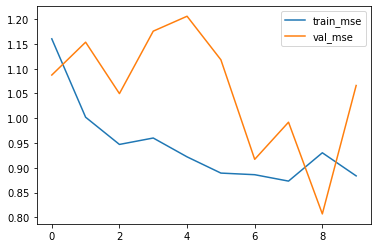

In [11]:
from matplotlib import pyplot

# plot training history
pyplot.plot(history.history['loss'], label='train_mse')
pyplot.plot(history.history['val_loss'], label='val_mse')
pyplot.legend()
pyplot.show()